In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd
#import importlib
from matplotlib.patches import Rectangle

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A = Masses['A'].to_numpy()
Z = Masses['Z'].to_numpy()
N = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [3]:
print(len(Energies))

258


In [4]:
# define parameter space

# hypercube
theta_0_bound = np.array([1, 7]).reshape(1,-1)
theta_1_bound = np.array([-0.4, -0]).reshape(1,-1)
theta_2_bound = np.array([0.3, 1.4]).reshape(1,-1)
theta_3_bound = np.array([0.00, 0.012]).reshape(1,-1) # keep
theta_4_bound = np.array([0.15, 0.5]).reshape(1,-1)
theta_5_bound = np.array([-0.2, 0.2]).reshape(1,-1)



parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)



theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[3,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[4,1], 100)
theta_5_vals = np.linspace(parameter_bounds[5,0], parameter_bounds[5,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1), theta_4_vals.reshape(1,-1), theta_5_vals.reshape(1,-1)), axis=0)


In [5]:
def LiquidDropModel(a0, a1, a2, a3, a4, a5, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
                + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(2*A**(-0.5))


#def LiquidDropModel(a0, a1, a2, a3, a4, A, Z, N):
    
    #return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
                #+ a4*((N-Z)**2)/A




In [6]:
# generate observational data with some uncertainty

noutputs = 20

start = 238
stop = 258
step = 1

#variables = np.concatenate((A[-noutputs:].reshape(-1,1),Z[-noutputs:].reshape(-1,1),\
                            #N[-noutputs:].reshape(-1,1)), axis=1)


variables = np.concatenate((A[start:stop:step].reshape(-1,1),Z[start:stop:step].reshape(-1,1),\
                            N[start:stop:step].reshape(-1,1)), axis=1)

print(len(A[start:stop:step]))

20


In [7]:
# Now we set up the design matrix X
X2 = np.zeros((len(A),4))
X2[:,0] = A
X2[:,1] = A**(2.0/3.0)
X2[:,2] = Z*(Z-1) * A**(-1.0/3.0)
X2[:,3] = (N-Z)**2 * A**(-1.0)


# Now we set up the design matrix X
X = np.zeros((len(A),6))
X[:,0] = np.ones_like(A)
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = Z*(Z-1) * A**(-1.0/3.0)
X[:,4] = (N-Z)**2 * A**(-1.0)
X[:,5] = ( (-1)**Z + (-1)**N )*(2*A**(-0.5))


In [8]:

clf = skl.LinearRegression(fit_intercept=False).fit(X, Energies)

print(clf.coef_)

preds = clf.predict(X)

#err = np.square(Energies-preds)

err = np.sum(np.square(Energies-preds))

print(err)

#pred_sigma = np.sqrt(np.var(err))
pred_sigma = np.sqrt(err / (len(Energies) - 5 - 1))

#https://stats.stackexchange.com/questions/284772/estimator-of-variance-of-error
                    
print(pred_sigma)


[ 4.73627103 -0.20205821  0.94821898  0.00784371  0.3234039   0.01146729]
1.552893362984103
0.07850016082745892


In [9]:
# generate observational data (for testing)

sigma_obs = Energies_unc

#https://www.int.washington.edu/users/bertsch/articles/369.pdf
sigma_model = pred_sigma

obs_data = Energies
#obs_data = LiquidDropModel(*clf.coef_, *variables.T)

In [10]:
nwaves = 4
ndim = 6
volshape = 'ellipsoid'

In [11]:
#importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(ndim, 'GP', volshape)

In [12]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel)

HM.set_observations(obs_data[start:stop:step], variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model)
HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1])

results = HM.run(nwaves=nwaves)

Running wave 1


100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


(9, 7)
Convergence : True
Relative nonimplausible volume remaining: 0.058
Running wave 2


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


(14455, 7)
Convergence : True
Relative nonimplausible volume remaining: 7.413
Running wave 3


100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


(16266, 7)
Convergence : True
Relative nonimplausible volume remaining: 6.86
Running wave 4


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]

(16966, 7)
Convergence : True
Relative nonimplausible volume remaining: 8.831


In [13]:
plot_wave = 1

print(results.nonimp_bounds)


[array([[ 1.7693500e+00,  6.8012500e+00],
       [-2.9609000e-01, -1.4423000e-01],
       [ 5.8531250e-01,  1.3442025e+00],
       [ 6.1227000e-03,  1.1014500e-02],
       [ 1.7330125e-01,  4.7235875e-01],
       [-1.2647000e-01,  1.7797000e-01]]), array([[-1.31391496e+00,  1.01339956e+01],
       [-3.89654964e-01, -8.00699309e-02],
       [ 2.53862230e-01,  1.82810570e+00],
       [ 1.36777560e-03,  1.47893853e-02],
       [ 1.35140245e-02,  6.45693014e-01],
       [-2.78201449e-01,  4.16320202e-01]]), array([[-1.83790126e+00,  1.04113787e+01],
       [-3.66970666e-01, -7.07462527e-02],
       [ 2.85359670e-01,  1.74787916e+00],
       [ 2.07049514e-03,  1.52449067e-02],
       [ 1.78632214e-03,  6.59368608e-01],
       [-2.68874560e-01,  3.92895572e-01]]), array([[-2.25953392e+00,  1.08100443e+01],
       [-3.63889552e-01, -5.53223596e-02],
       [ 2.22788288e-01,  1.84516798e+00],
       [ 2.13271195e-03,  1.56604749e-02],
       [ 4.21737454e-02,  7.09120475e-01],
       [-2.89675

In [14]:
#importlib.reload(plot)

#fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))

#plot.plotcorner(results.I_samples[4], parameter_bounds, ndim, bins=20, Fig=(fig,axes), labels=('a0', 'a1', 'a2', 'a3', 'a4', 'a5'))
#axes[1,0].scatter(clf.coef_[0],clf.coef_[1], color='red')
#axes[2,0].scatter(clf.coef_[0],clf.coef_[2], color='red')
#axes[2,1].scatter(clf.coef_[1],clf.coef_[2], color='red')
#axes[3,1].scatter(clf.coef_[1],clf.coef_[3], color='red')
#axes[2,3].scatter(clf.coef_[3],clf.coef_[2], color='red')

#for i in range(ndim):
    #axes[i,i].axvline(clf.coef_[i], color='red')

In [15]:
analytic_mean = np.loadtxt("data/LD_analytic_mean.txt").reshape(ndim,)
analytic_cov = np.loadtxt("data/LD_analytic_cov.txt").reshape(ndim,ndim)

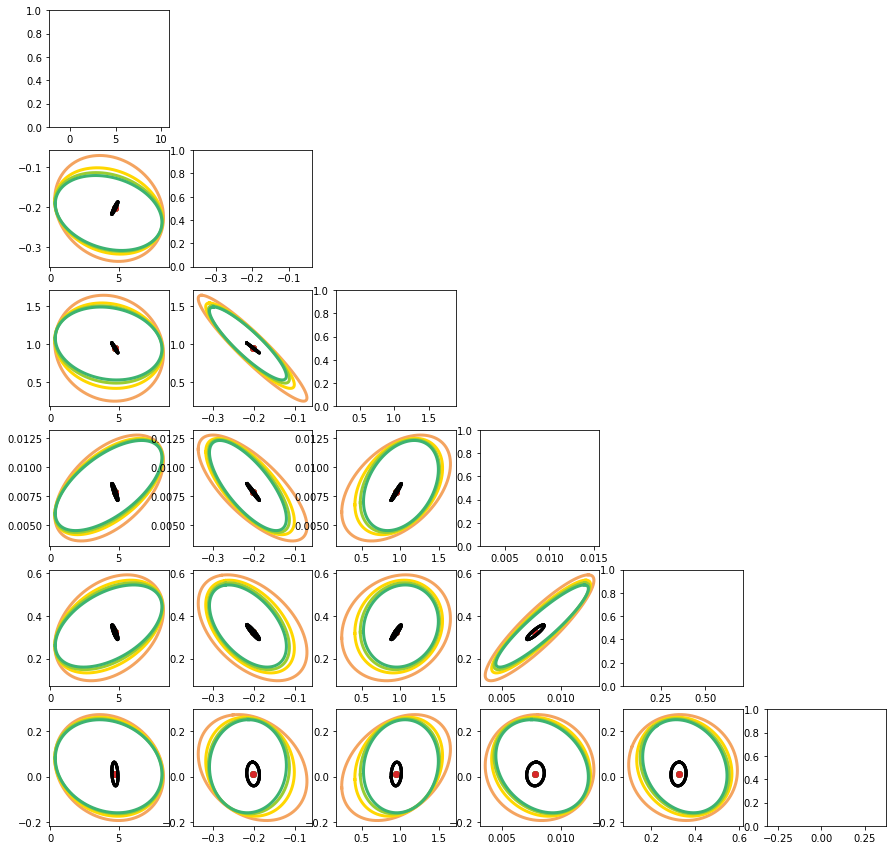

In [16]:
#importlib.reload(plot)

colors = ['sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'cornflowerblue', 'mediumpurple', 'plum', 'lightpink', ]

sample_bounds = utils.locate_boundaries(results.samples[-1], ndim)
tempbounds = np.concatenate((sample_bounds[-1].reshape(-1,1),sample_bounds[-1].reshape(-1,1)),axis=1).T

true = clf.coef_
#true = [15.92808016, -18.53454643,  -0.72795844, -23.73239355,]

fig, axes = plt.subplots(ndim, ndim, figsize=(15,15))
if volshape == 'ellipsoid':
    for k in range(nwaves):
        mean = np.mean(results.nonimplausible[k][:,:-1].T, axis=1)
        cov = np.cov(results.nonimplausible[k][:,:-1].T)
        
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    cov_matrix = np.array([[cov[i,i], cov[i,j]],[cov[j,i], cov[j,j]]])
                    plot.get_cov_ellipse(cov_matrix, [mean[i],mean[j]], 3, 5.991, ax, colors[k])
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    #ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    #ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.scatter(true[i],true[j])
                elif i == j:
                    #ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], mean[i], np.sqrt(cov[i,i])), color='plum')
                    ax.set_xlim([sample_bounds[i][0],sample_bounds[i][1]])
                    #ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.axis('off')
elif volshape == 'hypercube':
    for k in range(nwaves):
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    ax.add_patch(Rectangle((results.nonimp_bounds[k][i,0], results.nonimp_bounds[k][j,0]),\
                                           (results.nonimp_bounds[k][i,1]-results.nonimp_bounds[k][i,0]), \
                                           (results.nonimp_bounds[k][j,1]-results.nonimp_bounds[k][j,0]),\
                        color=colors[k],alpha=0.7,label='Nonimp. Hypercube'))
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.scatter(true[i],true[j])
                else:
                    ax.axis('off')


[ 4.73627103 -0.20205821  0.94821898  0.00784371  0.3234039   0.01146729]


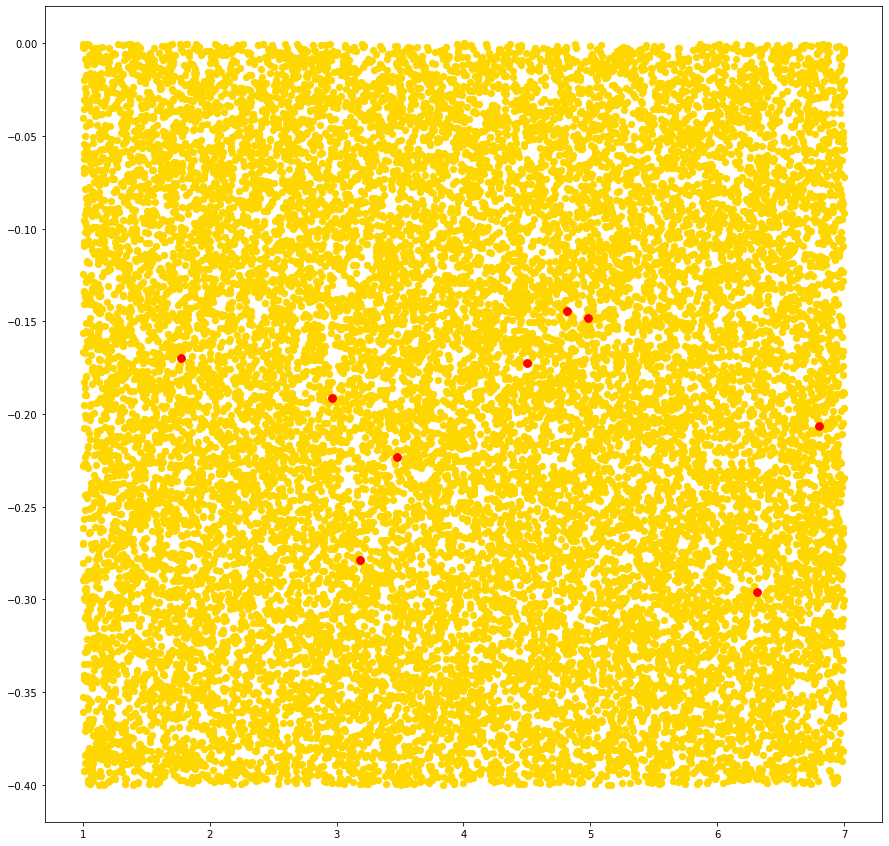

In [17]:
fig, ax = plt.subplots(figsize=(15,15))

col = np.where(results.I_samples[0][:,-1]<3,'g','r')
#col2 = np.where(results.I_samples[1][:,-1]<3,'g','r')
col = 'red'

#print(np.where(results.I_samples[0][:,-1]<3))
#ax.scatter(results.I_samples[0][:,0], results.I_samples[0][:,1], s=40, color=col, edgecolor='black')

ax.scatter(results.samples[0][:,0], results.samples[0][:,1], s=40, color='gold')
ax.scatter(results.nonimplausible[0][:,0], results.nonimplausible[0][:,1], s=60, color='red')

#ax.scatter(results.I_samples[1][:,0], results.I_samples[1][:,1], s=40, color=col2, edgecolor='black')

#ax.scatter(results.training_pts[0][:,0], results.training_pts[0][:,1], s=40, color=col, edgecolor='black')

#ax.set_xlim([1,5])
#ax.set_ylim([1,5])
print(true)


4.736271028722373
-0.20205820657778825
0.9482189781890055
0.007843705655382028
0.3234039047294424
0.011467294970662678


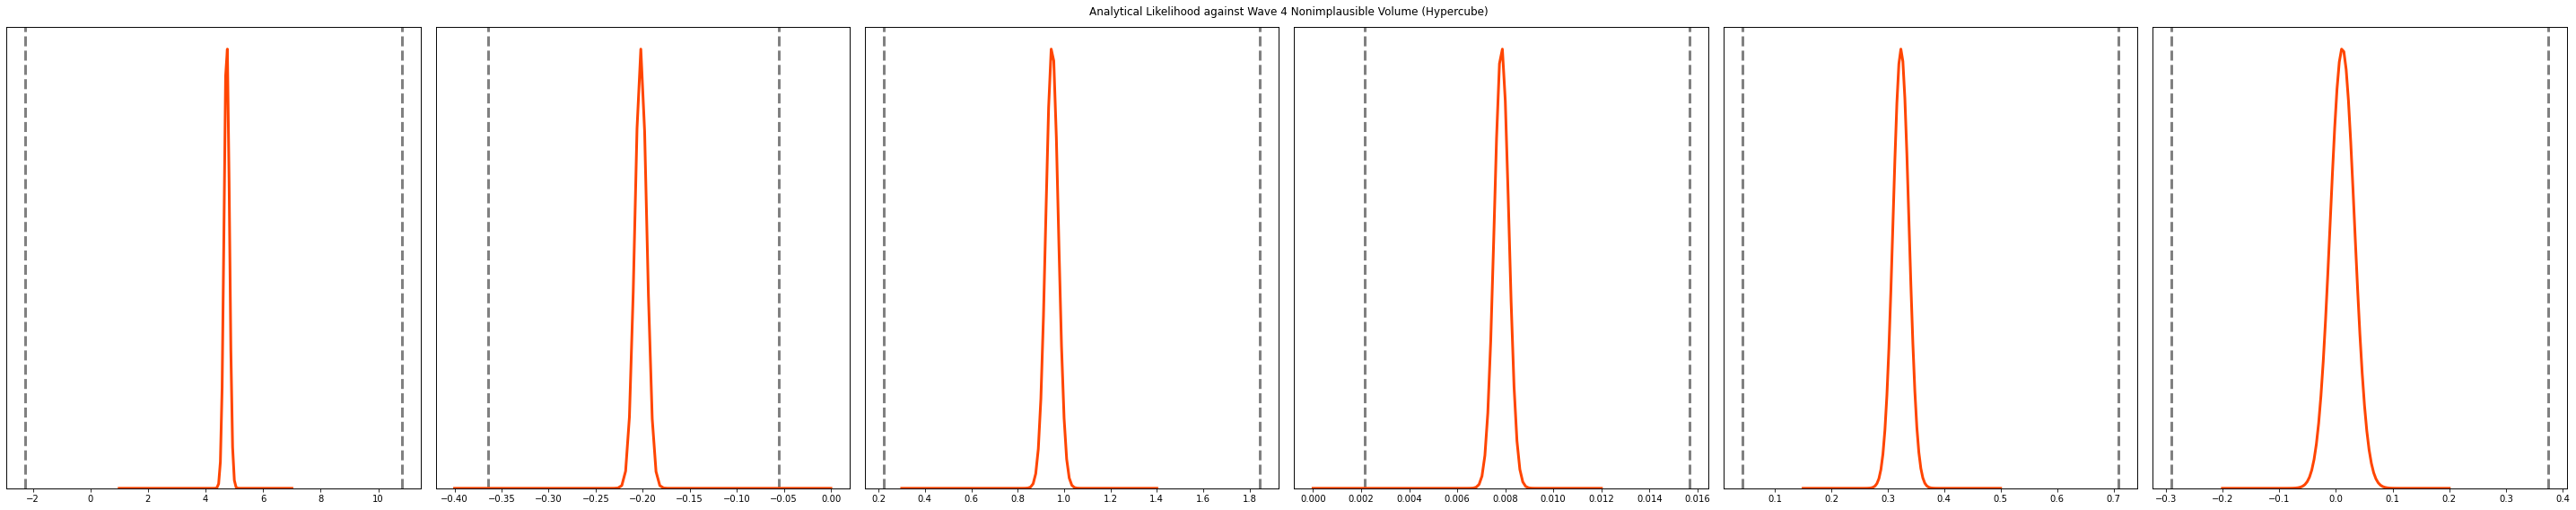

In [18]:
fig, axes = plt.subplots(1,ndim,figsize=(40,8))
theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']
#ax1_right = ax1.twinx()

for i in range(ndim):
    ax_right = axes[i].twinx()
    print(analytic_mean[i])
    #plot.opticaldepth_1D(final_wave_HC, parameter_bounds[i], i, bins=50, Fig=(fig, axes[i]), plot_kwargs={'color': 'lightblue'})
    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], analytic_mean[i],\
                                                np.sqrt(analytic_cov[i,i])), color='orangered', linewidth=3, label='Posterior Distribution')
    axes[i].set(yticklabels=[])  
    axes[i].tick_params(left=False)
    ax_right.set(yticklabels=[])  
    ax_right.tick_params(right=False)
    
    #for j in range(nwaves):
    
    min_a = np.min(results.nonimplausible[3][:,i].T[:-1])
    max_a = np.max(results.nonimplausible[3][:,i].T[:-1])
    axes[i].axvline(min_a, color='grey', linestyle='--', linewidth=3)
    axes[i].axvline(max_a, color='grey', linestyle='--', linewidth=3)
    
    #ax_right.axvline(max_theta1, color='cornflowerblue', linestyle='--', linewidth=3, label=r'Wave 1 Nonimplausible Vol. Limits')
    #ax_right.axvline(max_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(max_theta3, color='grey', linestyle='--', linewidth=3, label=r'Nonimplausible Vol. Limits')
    
    #ax_right.axvline(min_theta1, color='cornflowerblue', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta2, color='orange', linestyle='--', linewidth=3)
    #ax_right.axvline(min_theta3, color='grey', linestyle='--', linewidth=3)
    
    axes[i].set_ylim([0, None])
    ax_right.set_ylim([0, None])
    #ax_right.set(yticklabels=[])
    
    
    #axes[i].set_xlabel(theta_names[i])
    #ax_right.tick_params(right=False)
    
    #axes[i].set_xticks([-1,-0.5,0,0.5,1]) 
    #axes[i].set_xticklabels([-1.0, -0.5, 0, 0.5, 1.0])
    
    #handles, labels = ax_right.get_legend_handles_labels()
    #patch = mpatches.Patch(color='lightblue', label='Optical Depth')
    #handles.append(patch) 
    #plt.legend(handles=handles, loc='best')
    
    
fig.suptitle('Analytical Likelihood against Wave 4 Nonimplausible Volume (Hypercube)')
plt.tight_layout()

plt.savefig('figures/final_HC.png', bbox_inches='tight', facecolor='white', transparent=False)